# Reverse parentheses

Given a row "123(2335(345))234(3)", reverse strings inside each pair of (), starting from the innermost, removing () themselves in the process. For example, "12(34)56" should become "124356".

In [14]:
def simple(s):
    """Simple ineffective n^2 solution"""
    stack = []
    sl = list(s) # Just to manipulate it in-place
    for i in range(len(s)):
        if s[i]=='(':
            stack.append(i)
        if s[i]==')':
            left = stack.pop()
            sl[(left+1):i] = sl[(i-1):left:-1]
    return ''.join([q if q not in ['(',')'] else '' for q in sl])

print(simple('1(234)5(678(90))'))

1432590876


### Approach with a tree of segments

* We represent the text as a tree of segments. Each segment knows its left and right edges, whether it needs to be reversed, and a list of next-level children, in the same order in which they are given at the text.
* Each node either contains kids, or contains text only (end-level, leaf). So any flat text within a mixed node should be framed inside a node (like adding invisible non-flipping parentheses).
* First we populate the tree:
    * Start a root node. set flip to 0. Set left at 0. Set current node type to flat. 
    * Keep going right.
    * On (: 
        * Check if there was a head (now>current left +1). If yes, make everything between left and now into a child node with
            * flip = current flip.
            * left = current node left
            * right = now
        * Set current node type to complex.
        * Create a new node, make it a child. Set:
            * left = now
            * flip = opposite flip
        *  Get inside this new node
    * On ):
        * Set node right to now (won't hurt, although complex nodes don't care)
        * If it has kids, make everything between right of the last kid and now a flat node with current flip. Add this node to children.
        * Go one level higher (so nodes should remember their parents).
* Reconstruct the tree recursively:
    * Start with root node
    * If this node has no kids - just add the text between left and right, either flipping it or not, depending on its flip status
    * if not, check the flip status. Go recursively through all children, either in correct order (if flipped==0), or reverse order.

In [94]:
# Now let's try a fancier solution that doesn't reverse rows without need
class Solution:
    class Node():
        """Special tree to store pieces of text"""
        def __init__(self,parent=None,left=None,right=None,flip=0):
            self.l = left
            self.r = right
            self.flip = flip # Unflipped by default
            self.kids = []
            self.parent = parent
            
        def __str__(self):
            if len(self.kids)>0:
                return f'l{self.l} r{self.r} f{self.flip}' + '[' + '|'.join([q.__str__() for q in self.kids])+ ']'
            else:
                return f'l{self.l} r{self.r} f{self.flip}'

    def process(self,s):
        t = self.Node(None,0,len(s),0)
        p = t # Current pointer
        flip = 0
        left = 0
        for i in range(len(s)):
            if s[i]=='(':
                if i-left>0: # There was a head
                    k = self.Node(p, left, i, p.flip)
                    p.kids.append(k)
                k = self.Node(p, i+1, None, 1-p.flip)
                p.kids.append(k)
                p = k # Step in
                left = i+1
            if s[i]==')':
                p.r = i
                if len(p.kids)>0:
                    if i-left>0: # There's a tail
                        k = self.Node(p, left, i, p.flip)
                        p.kids.append(k)
                p = p.parent # Step out
                left = i+1
            if i==len(s)-1: # Special case - the top-level node has a tail
                if len(p.kids)>0:
                    if i-left>=0: # There's a tail
                        k = self.Node(p, left, i+1, p.flip)
                        p.kids.append(k)
                        
        #print(t)
                        
        out = self.output(s,t) # May still contain some () if there were (( or )) in the original string
        return ''.join([q if q not in ['(',')'] else '' for q in list(out)])
    
    def output(self,s,node):
        if len(node.kids)==0:
            if node.flip==0:
                return s[node.l:node.r]
            else:
                return s[node.r-1:node.l-1:-1]
        if node.flip==0:
            return ''.join([self.output(s,k) for k in node.kids])
        else:
            return ''.join([self.output(s,k) for k in node.kids[::-1]])
                

# tests
f = Solution()
print(f.process('0(23(56))9'))

print(simple('1(234)5(678(90))'))
print(f.process('1(234)5(678(90))'))

056329
1432590876
1432590876


In [173]:
# Tester
import numpy as np

def generate(length):
    seed = ['(',')']
    s = ['']
    prob = 0.3
    for j in range(length):
        split = np.random.randint(len(s))
        if np.random.uniform()<prob:
            s = s[:split]+seed+s[split:]
        else:
            s = s[:split]+[str(q) for q in np.random.randint(10,size=2)]+s[split:]
    return ''.join(s)

n_tests = 10
length = 30
for i in range(n_tests):
    print(generate(length))

436543()6531()()7(6()9258309()928(())4)(()90334271)700()6014
63()9822()6676(((34)))802(8866)62()9(63)()6559(8040)338722()
355357()9()(())()7527627(01)9160465()63()0()9143179077708975
()24(95)()()68()2745(08()91(29)29()()56()())521()7()79035113
()0()(1970()754()8522533()(64)21)17(420()389())(())123(45)()
368()33()()()(()()47)8982087118241680((7307))()()64()((22))6
941()0041((48)()26192()031)33(333761())661()504256(5898)7612
()933()(93)()()05(22)(())()99280261127()2772()58(155574())63
()()95()6013870089()(90())()525()8()6512708()4()819126()()32
2512926()(4946)7306746730609485857()509()19486244()90714(72)


[100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
..................

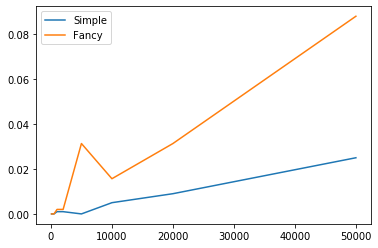

In [197]:
# Benchmarking

import time
import matplotlib.pyplot as plt

f = Solution()
lengths = [j*10**i for i in range(2,5) for j in [1,2,5]]
print(lengths)
methods = [simple, f.process]
n_tries = 1

history = np.zeros(shape=(len(lengths),2))
for ifun in range(len(methods)):
    fun = methods[ifun]
    for il in range(len(lengths)):
        for _ in range(n_tries):
            s = generate(lengths[il])
            tic = time.time()
            fun(s)
            history[il,ifun] += time.time()-tic
        print('.',end='')
history = history/n_tries
        
# plotting

for i in range(history.shape[1]):
    plt.plot(lengths,history[:,i]);
plt.legend(['Simple','Fancy']);

OK, nice, my supposdly 'smarter" solution is wa-ay slower than a simple solution, and with no sign of reversal at hith n. Hmm. Probably the smart solution wasn't that smart after all